In [1]:
%load_ext autoreload
%autoreload 2
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import transformers
from transformers import AdamW
from transformers import AutoModel, BertTokenizerFast
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from process_data import *
from models.bert_mlp_v1 import *
from training import train
from evaluation import evaluate
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df_zoo_train, df_zoo_test = load_data("../data")
df_zoo_train.head()

,Record_id,Attribute_name,y_act,total_vals,num_nans,%_nans,num_of_dist_val,%_dist_val,mean,std_dev,...,mean_stopword_total,stdev_stopword_total,mean_char_count,stdev_char_count,mean_whitespace_count,stdev_whitespace_count,mean_delim_count,stdev_delim_count,is_list,is_long_sentence
0,33,Area,categorical,21477,0,0.0,174,0.810169,0.000000,0.000000,...,0.2,0.4,10.0,4.816638,0.4,0.8,0.4,0.8,False,False
1,33,Area Code,categorical,21477,0,0.0,174,0.810169,125.449411,72.866452,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,False,False
2,33,Element,categorical,21477,0,0.0,2,0.009312,0.000000,0.000000,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
3,33,Element Code,categorical,21477,0,0.0,2,0.009312,5211.687154,146.816661,...,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,0.0,False,False
4,33,Item,categorical,21477,0,0.0,115,0.535457,0.000000,0.000000,...,0.8,0.4,19.6,2.244994,2.0,0.0,2.0,0.0,False,False


In [3]:
train_data = preprocess_bert(df_zoo_train)
test_data = preprocess_bert(df_zoo_test)
train_data.head()

,text,features,label
0,Area [SEP] Afghanistan [SEP] Albania [SEP] Alg...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
1,Area Code [SEP] 2 [SEP] 3 [SEP] 4 [SEP] 7 [SEP] 8,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
2,Element [SEP] Food [SEP] Feed [SEP] Food [SEP]...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
3,Element Code [SEP] 5142 [SEP] 5521 [SEP] 5142 ...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0
4,Item [SEP] Wheat and products [SEP] Rice (Mill...,"[1.058161729698188, -0.49520412160069144, 0.0,...",1.0


In [5]:
x_train, x_val, y_train, y_val = train_test_split(train_data[['text', "features"]], train_data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=train_data['label'])

In [6]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
model_name = "bert_mlp_v1"

In [8]:
device = torch.device("cuda")

In [9]:
for param in bert.parameters():
    param.requires_grad = False

In [10]:
train_dataloader, val_dataloader, test_dataloader = init_dataloaders_bert(x_train, y_train, x_val, y_val, test_data)

/home/tamittal/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2198: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [26]:
model = BERT_mlp_v1(bert)

model = model.to(device)

In [44]:
# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-8)

# number of training epochs
epochs = 25

In [28]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print("Class Weights:",class_weights)

Class Weights: [0.3034519  0.47585845 1.64387464 3.05291005 7.66545894 1.88059259
 4.63961988 1.00890161 1.25261496]


In [34]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

In [30]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

In [45]:
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _, = train(model, train_dataloader, optimizer, cross_entropy)
    
    #evaluate model
    valid_loss, _, valid_acc = evaluate(model, val_dataloader, cross_entropy, y_val)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../models/exports/%s.pt' % model_name)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_acc:.3f}')


 Epoch 1 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.768
Validation Loss: 0.856
Validation Accuracy: 0.706

 Epoch 2 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.745
Validation Loss: 0.856
Validation Accuracy: 0.706

 Epoch 3 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.769
Validation Loss: 0.856
Validation Accuracy: 0.706

 Epoch 4 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.752
Validation Loss: 0.856
Validation Accuracy: 0.706

 Epoch 5 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evaluating...

Training Loss: 0.765
Validation Loss: 0.856
Validation Accuracy: 0.706

 Epoch 6 / 25
  Batch    50  of    199.
  Batch   100  of    199.
  Batch   150  of    199.

Evalua

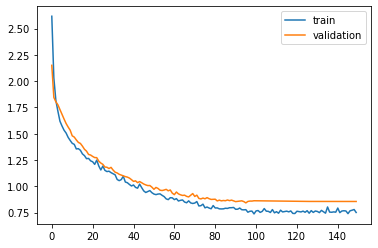

In [46]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train", "validation"])

In [47]:
loss, preds, acc = evaluate(model,test_dataloader, cross_entropy, test_data["label"])
print("test_accuracy:", acc)


Evaluating...
  Batch    50  of     63.
test_accuracy: 0.7314861460957179
